**Using TSNE**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load and preprocess df1
df1 = pd.read_excel('EOGsignal.xlsx').iloc[:, 1:]
df1.columns = ['f' + str(i) for i in range(0, 24)] + ['class']
X1 = df1.drop(['class'], axis=1)
y1 = df1['class']

# Load and preprocess df2
df2 = pd.read_csv('EMGF1.csv')
df2 = df2.drop(columns=['time'])
df2.columns = ['f' + str(i) for i in range(0, 8)] + ['class']

# Filter df2 to include only classes present in df1
valid_classes = df1['class'].unique()
df2 = df2[df2['class'].isin(valid_classes)]

X2 = df2.drop(['class'], axis=1)
y2 = df2['class']


# Apply 3D t-SNE for df1
tsne = TSNE(n_components=3, random_state=23)
X1_tsne = tsne.fit_transform(X1)

# Apply 3D t-SNE for df2
X2_tsne = tsne.fit_transform(X2)

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
X1_scaled = scaler.fit_transform(X1_tsne)
X2_scaled = scaler.fit_transform(X2_tsne)

# Split data into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y1, test_size=0.1, random_state=23)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y2, test_size=0.1, random_state=23)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X1_train_resampled, y1_train_resampled = smote.fit_resample(X1_train, y1_train)
X2_train_resampled, y2_train_resampled = smote.fit_resample(X2_train, y2_train)


**EOG (Histogram of TSNE Component)**

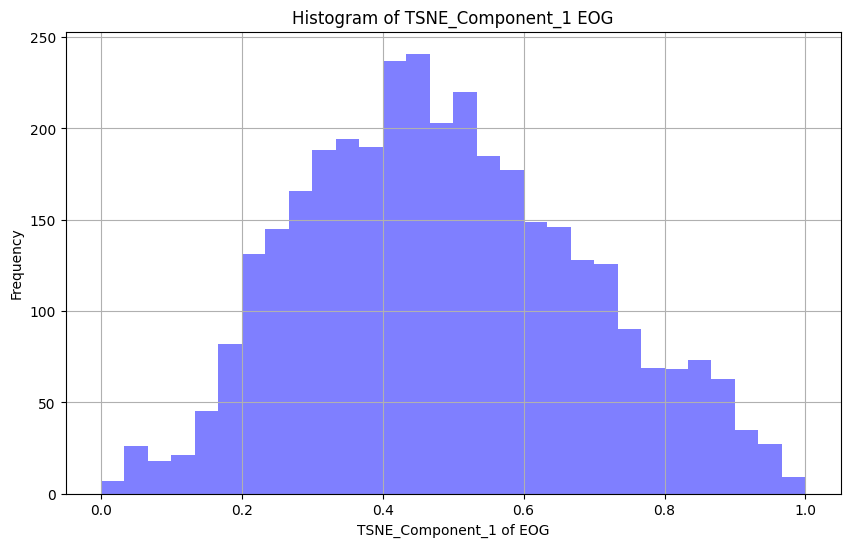

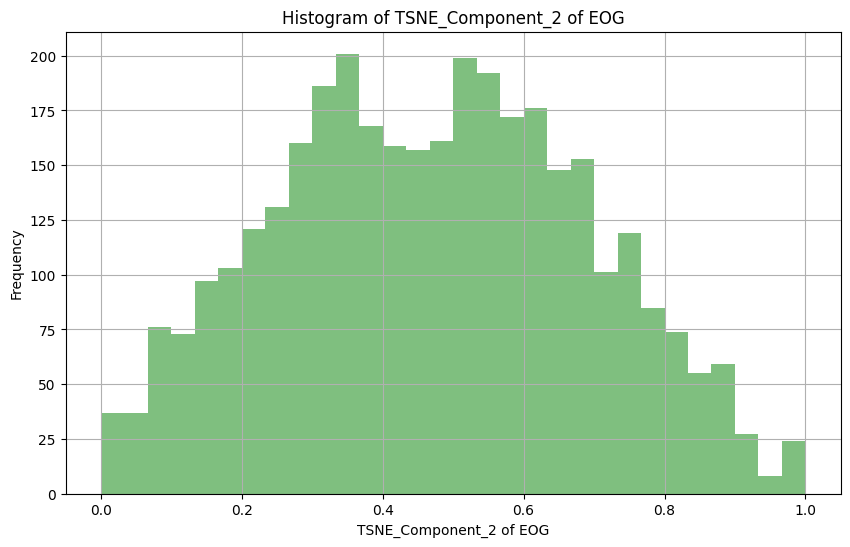

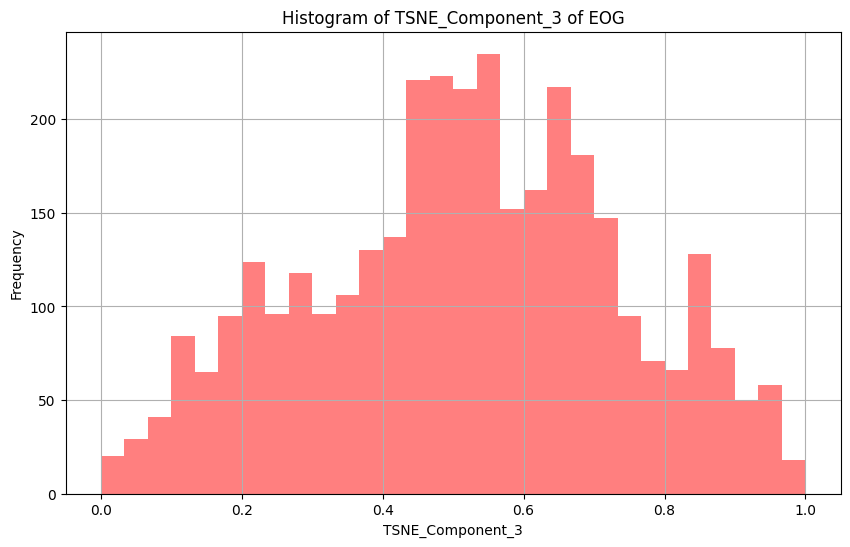

In [3]:
import matplotlib.pyplot as plt

# Plot histograms for TSNE Component 1
plt.figure(figsize=(10, 6))
plt.hist(X1_scaled[:, 0], bins=30, alpha=0.5, color='blue')
plt.xlabel('TSNE_Component_1 of EOG')
plt.ylabel('Frequency')
plt.title('Histogram of TSNE_Component_1 EOG')
plt.grid(True)
plt.show()

# Plot histograms for TSNE Component 2
plt.figure(figsize=(10, 6))
plt.hist(X1_scaled[:, 1], bins=30, alpha=0.5, color='green')
plt.xlabel('TSNE_Component_2 of EOG')
plt.ylabel('Frequency')
plt.title('Histogram of TSNE_Component_2 of EOG')
plt.grid(True)
plt.show()

# Plot histograms for TSNE Component 3
plt.figure(figsize=(10, 6))
plt.hist(X1_scaled[:, 2], bins=30, alpha=0.5, color='red')
plt.xlabel('TSNE_Component_3')
plt.ylabel('Frequency')
plt.title('Histogram of TSNE_Component_3 of EOG')
plt.grid(True)
plt.show()


**EMG (Histogram of TSNE Component)**

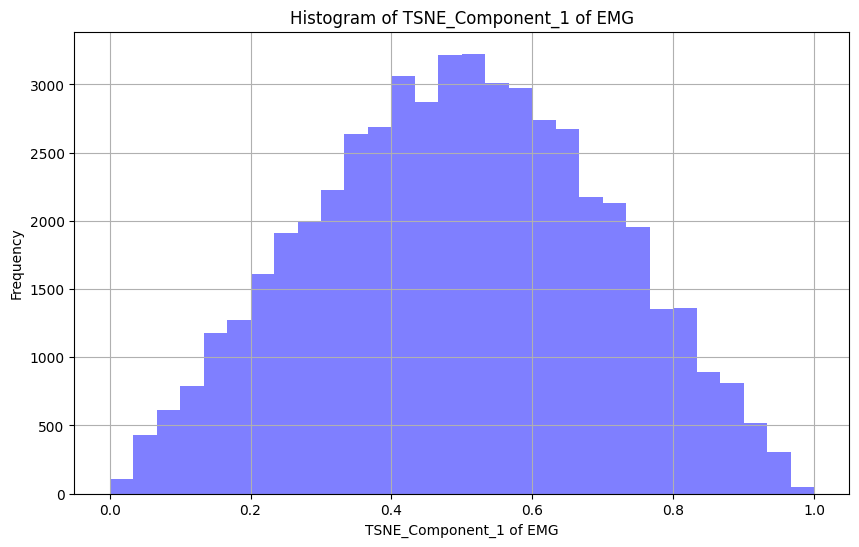

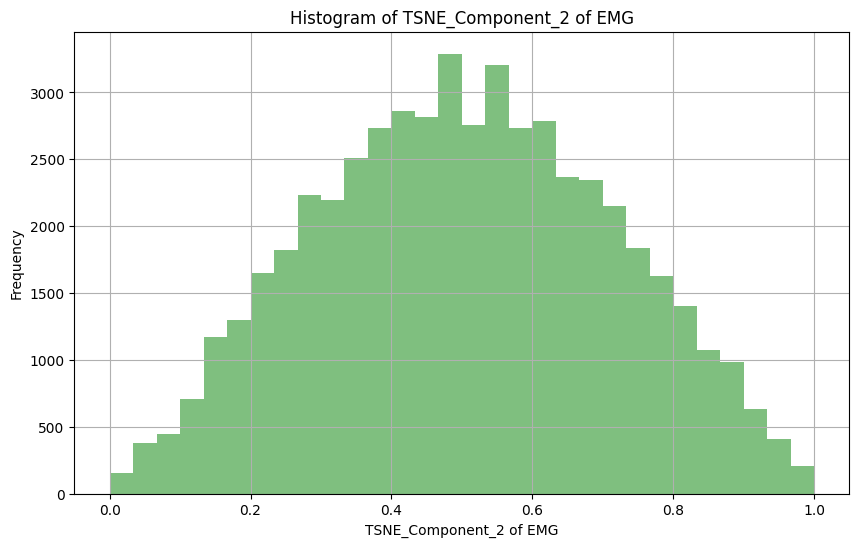

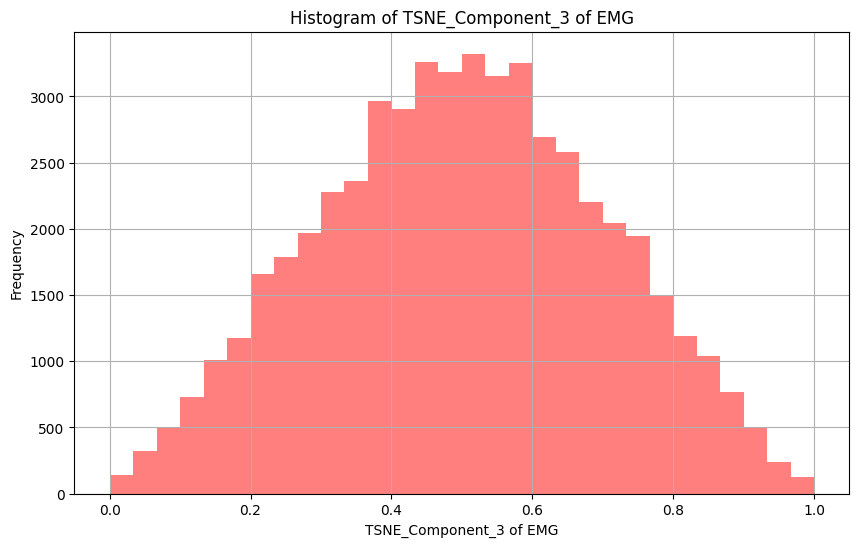

In [4]:
import matplotlib.pyplot as plt

# Plot histograms for TSNE Component 1
plt.figure(figsize=(10, 6))
plt.hist(X2_scaled[:, 0], bins=30, alpha=0.5, color='blue')
plt.xlabel('TSNE_Component_1 of EMG')
plt.ylabel('Frequency')
plt.title('Histogram of TSNE_Component_1 of EMG')
plt.grid(True)
plt.show()

# Plot histograms for TSNE Component 2
plt.figure(figsize=(10, 6))
plt.hist(X2_scaled[:, 1], bins=30, alpha=0.5, color='green')
plt.xlabel('TSNE_Component_2 of EMG')
plt.ylabel('Frequency')
plt.title('Histogram of TSNE_Component_2 of EMG')
plt.grid(True)
plt.show()

# Plot histograms for TSNE Component 3
plt.figure(figsize=(10, 6))
plt.hist(X2_scaled[:, 2], bins=30, alpha=0.5, color='red')
plt.xlabel('TSNE_Component_3 of EMG')
plt.ylabel('Frequency')
plt.title('Histogram of TSNE_Component_3 of EMG')
plt.grid(True)
plt.show()


**Defining Classifier and ensemble**

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb


# Define classifiers with additional models
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': xgb.XGBClassifier()
}

# Create and train ensemble models for df1 (EOG) with additional models
voting_clf_df1 = VotingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier()),
        ('rf', RandomForestClassifier()),
        ('knn', KNeighborsClassifier()),
        ('gb', GradientBoostingClassifier()),
        ('svm', SVC(probability=True)),
        ('xgb', xgb.XGBClassifier())
    ],
    voting='hard'  # Use hard voting
)
voting_clf_df1.fit(X1_train_resampled, y1_train_resampled)

# Create and train ensemble models for df2 (EMG) with additional models
voting_clf_df2 = VotingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier()),
        ('rf', RandomForestClassifier()),
        ('knn', KNeighborsClassifier()),
        ('gb', GradientBoostingClassifier()),
        ('svm', SVC(probability=True)),
        ('xgb', xgb.XGBClassifier())
    ],
    voting='hard'  # Use hard voting
)
voting_clf_df2.fit(X2_train_resampled, y2_train_resampled)

# Get predictions from the df1 (EOG) and df2 (EMG) ensemble models on test data
df1_test_predictions = voting_clf_df1.predict(X1_test)
df2_test_predictions = voting_clf_df2.predict(X2_test)

# Ensure equal number of samples in both datasets
min_samples = min(len(X1_train_resampled), len(X2_train_resampled))

X1_train_resampled, y1_train_resampled = X1_train_resampled[:min_samples], y1_train_resampled[:min_samples]
X2_train_resampled, y2_train_resampled = X2_train_resampled[:min_samples], y2_train_resampled[:min_samples]

# Combine predictions from the training data for stacking
X_combined_train = pd.DataFrame({
    'df1': voting_clf_df1.predict(X1_train_resampled),
    'df2': voting_clf_df2.predict(X2_train_resampled)
})

# Training labels for the stacking model
y_combined_train = y1_train_resampled  # Use the labels from df1 as reference

# Define the base models for stacking
estimators = [
    ('voting_df1', voting_clf_df1),
    ('voting_df2', voting_clf_df2)
]

# Create and train the StackingClassifier with additional models
stacked_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier()  # You can choose any other classifier as the final estimator
)

stacked_clf.fit(X_combined_train, y_combined_train)


StackingClassifier(estimators=[('voting_df1',
                                VotingClassifier(estimators=[('dt',
                                                              DecisionTreeClassifier()),
                                                             ('rf',
                                                              RandomForestClassifier()),
                                                             ('knn',
                                                              KNeighborsClassifier()),
                                                             ('gb',
                                                              GradientBoostingClassifier()),
                                                             ('svm',
                                                              SVC(probability=True)),
                                                             ('xgb',
                                                              XGBClassifier(base_score=None,
                                                                            booster=None,
                                                                            callbacks=None,
                                                                            colsample_bylevel=None,
                                                                            colsample_bynode=None,
                                                                            colsa...
                                                                            interaction_constraints=None,
                                                                            learning_rate=None,
                                                                            max_bin=None,
                                                                            max_cat_threshold=None,
                                                                            max_cat_to_onehot=None,
                                                                            max_delta_step=None,
                                                                            max_depth=None,
                                                                            max_leaves=None,
                                                                            min_child_weight=None,
                                                                            missing=nan,
                                                                            monotone_constraints=None,
                                                                            multi_strategy=None,
                                                                            n_estimators=None,
                                                                            n_jobs=None,
                                                                            num_parallel_tree=None,
                                                                            random_state=None, ...))]))],
                   final_estimator=RandomForestClassifier())

**Evaluating the EOG**

Performance of individual classifiers for EOG:

Classifier: Decision Tree
Accuracy: 0.9711
F1 Score: 0.9710
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        63
           1       1.00      0.97      0.99        76
           2       0.96      1.00      0.98        79
           3       0.93      0.95      0.94        55
           4       0.97      1.00      0.99        73

    accuracy                           0.97       346
   macro avg       0.97      0.97      0.97       346
weighted avg       0.97      0.97      0.97       346



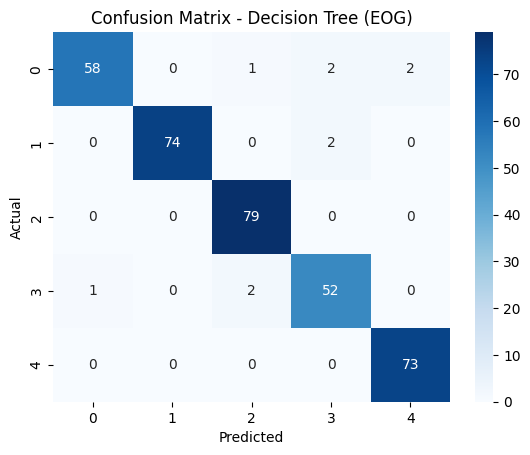


Classifier: Random Forest
Accuracy: 0.9913
F1 Score: 0.9913
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98        63
           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        79
           3       0.96      0.98      0.97        55
           4       1.00      1.00      1.00        73

    accuracy                           0.99       346
   macro avg       0.99      0.99      0.99       346
weighted avg       0.99      0.99      0.99       346



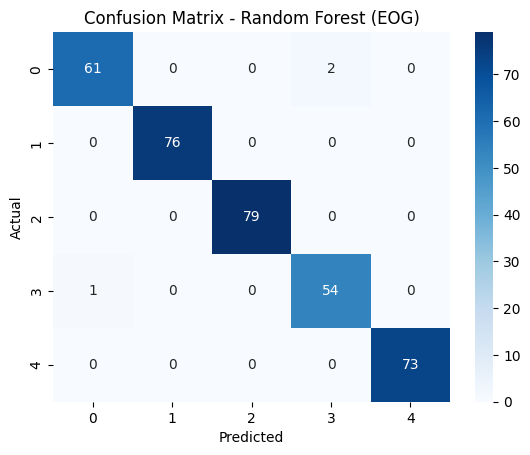


Classifier: KNN
Accuracy: 0.9942
F1 Score: 0.9942
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        63
           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        79
           3       0.98      0.98      0.98        55
           4       1.00      1.00      1.00        73

    accuracy                           0.99       346
   macro avg       0.99      0.99      0.99       346
weighted avg       0.99      0.99      0.99       346



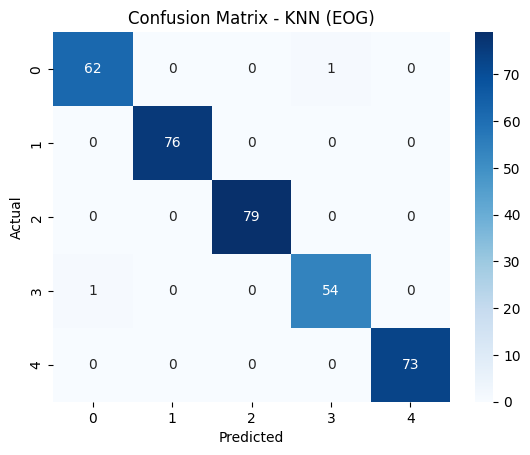


Classifier: Gradient Boosting
Accuracy: 0.9769
F1 Score: 0.9769
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        63
           1       0.99      1.00      0.99        76
           2       0.99      0.99      0.99        79
           3       0.95      0.95      0.95        55
           4       1.00      0.99      0.99        73

    accuracy                           0.98       346
   macro avg       0.97      0.97      0.97       346
weighted avg       0.98      0.98      0.98       346



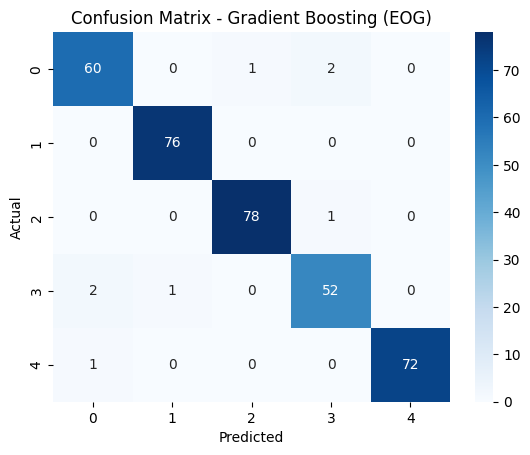


Classifier: SVM
Accuracy: 0.9827
F1 Score: 0.9828
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        63
           1       0.99      0.99      0.99        76
           2       1.00      1.00      1.00        79
           3       0.92      0.98      0.95        55
           4       1.00      1.00      1.00        73

    accuracy                           0.98       346
   macro avg       0.98      0.98      0.98       346
weighted avg       0.98      0.98      0.98       346



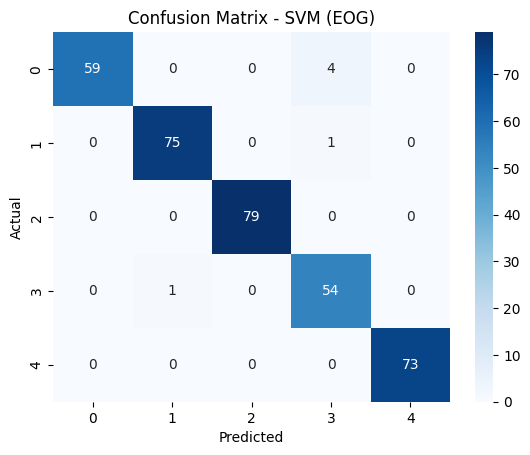


Classifier: XGBoost
Accuracy: 0.9884
F1 Score: 0.9884
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        63
           1       1.00      1.00      1.00        76
           2       0.99      1.00      0.99        79
           3       0.96      0.98      0.97        55
           4       1.00      1.00      1.00        73

    accuracy                           0.99       346
   macro avg       0.99      0.99      0.99       346
weighted avg       0.99      0.99      0.99       346



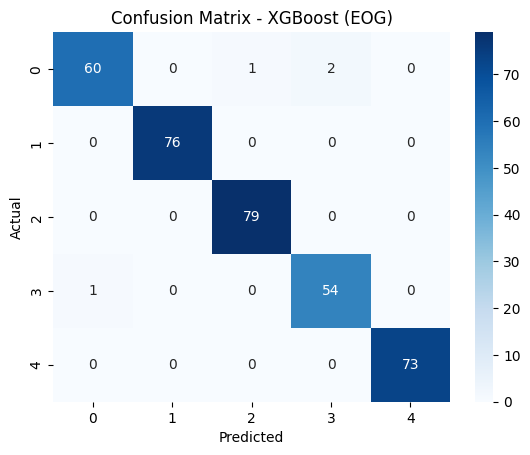


Performance of ensemble model (Voting Classifier) for EOG:
Accuracy: 0.9913
F1 Score: 0.9913
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98        63
           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        79
           3       0.96      0.98      0.97        55
           4       1.00      1.00      1.00        73

    accuracy                           0.99       346
   macro avg       0.99      0.99      0.99       346
weighted avg       0.99      0.99      0.99       346



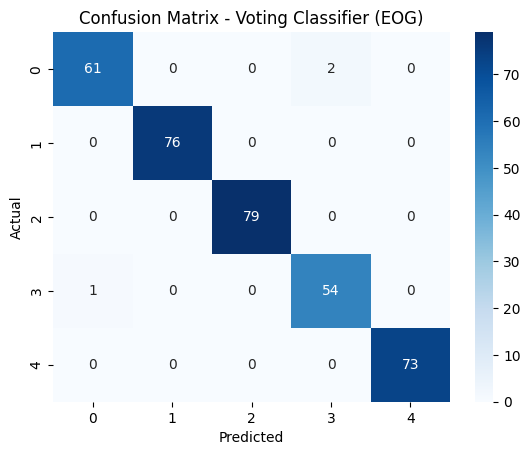

In [8]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Evaluate individual classifiers for df1
print("Performance of individual classifiers for EOG:")
for name, clf in classifiers.items():
    clf.fit(X1_train_resampled, y1_train_resampled)
    y_pred = clf.predict(X1_test)
    
    print(f"\nClassifier: {name}")
    print(f"Accuracy: {accuracy_score(y1_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y1_test, y_pred, average='weighted'):.4f}")
    print("Classification Report:")
    print(classification_report(y1_test, y_pred))
    
    # Plot confusion matrix
    plot_confusion_matrix(y1_test, y_pred, f'Confusion Matrix - {name} (EOG)')

# Evaluate the ensemble model for df1
print("\nPerformance of ensemble model (Voting Classifier) for EOG:")
y_pred_df1_ensemble = voting_clf_df1.predict(X1_test)
print(f"Accuracy: {accuracy_score(y1_test, y_pred_df1_ensemble):.4f}")
print(f"F1 Score: {f1_score(y1_test, y_pred_df1_ensemble, average='weighted'):.4f}")
print("Classification Report:")
print(classification_report(y1_test, y_pred_df1_ensemble))

# Plot confusion matrix for ensemble model
plot_confusion_matrix(y1_test, y_pred_df1_ensemble, 'Confusion Matrix - Voting Classifier (EOG)')


**Evaluating the EMG**

Performance of individual classifiers for EMG:

Classifier: Decision Tree
Accuracy: 0.8090
F1 Score: 0.8103
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3988
           1       0.59      0.55      0.57       381
           2       0.60      0.58      0.59       332
           3       0.58      0.71      0.64       292
           4       0.57      0.64      0.60       285

    accuracy                           0.81      5278
   macro avg       0.65      0.67      0.66      5278
weighted avg       0.81      0.81      0.81      5278



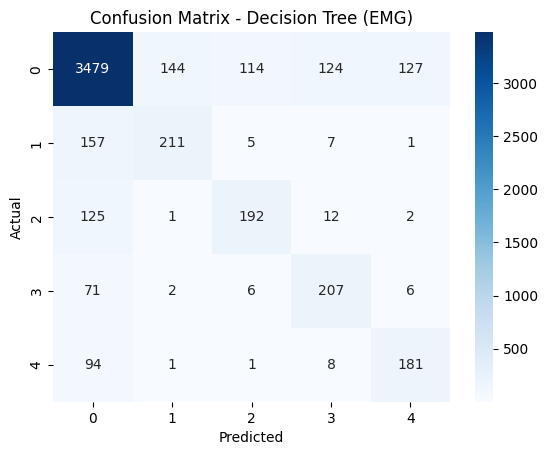


Classifier: Random Forest
Accuracy: 0.8696
F1 Score: 0.8564
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      3988
           1       0.86      0.42      0.57       381
           2       0.92      0.52      0.67       332
           3       0.86      0.66      0.75       292
           4       0.90      0.57      0.70       285

    accuracy                           0.87      5278
   macro avg       0.88      0.63      0.72      5278
weighted avg       0.87      0.87      0.86      5278



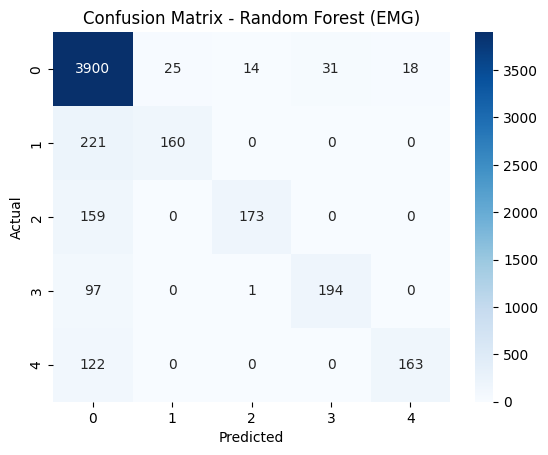


Classifier: KNN
Accuracy: 0.7656
F1 Score: 0.7412
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      3988
           1       0.41      0.22      0.29       381
           2       0.53      0.30      0.39       332
           3       0.61      0.41      0.49       292
           4       0.53      0.31      0.39       285

    accuracy                           0.77      5278
   macro avg       0.58      0.43      0.48      5278
weighted avg       0.74      0.77      0.74      5278



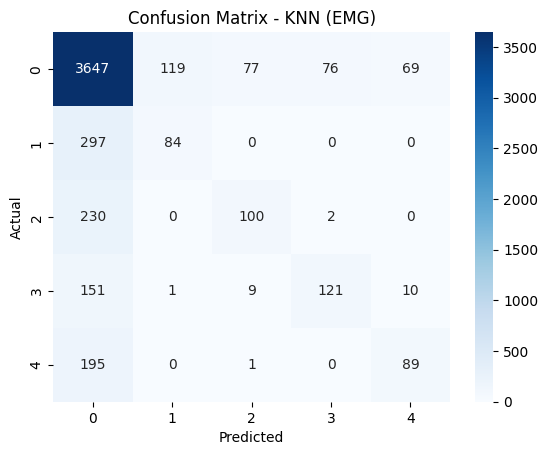


Classifier: Gradient Boosting
Accuracy: 0.7817
F1 Score: 0.7197
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.98      0.87      3988
           1       0.92      0.03      0.06       381
           2       0.72      0.17      0.28       332
           3       0.71      0.32      0.44       292
           4       0.79      0.16      0.26       285

    accuracy                           0.78      5278
   macro avg       0.79      0.33      0.38      5278
weighted avg       0.79      0.78      0.72      5278



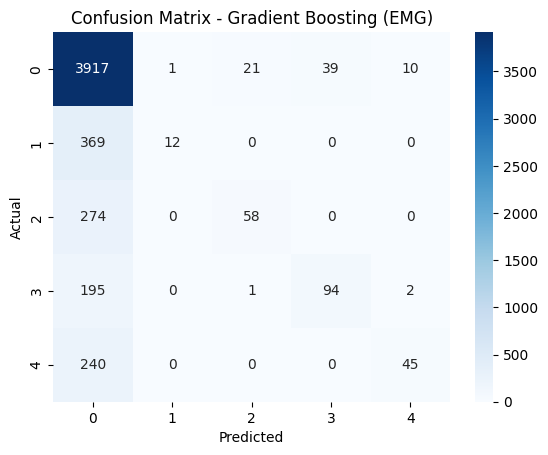


Classifier: SVM
Accuracy: 0.7556
F1 Score: 0.6504
Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      3988
           1       0.00      0.00      0.00       381
           2       0.00      0.00      0.00       332
           3       0.00      0.00      0.00       292
           4       0.00      0.00      0.00       285

    accuracy                           0.76      5278
   macro avg       0.15      0.20      0.17      5278
weighted avg       0.57      0.76      0.65      5278



/home/love/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/love/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/love/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


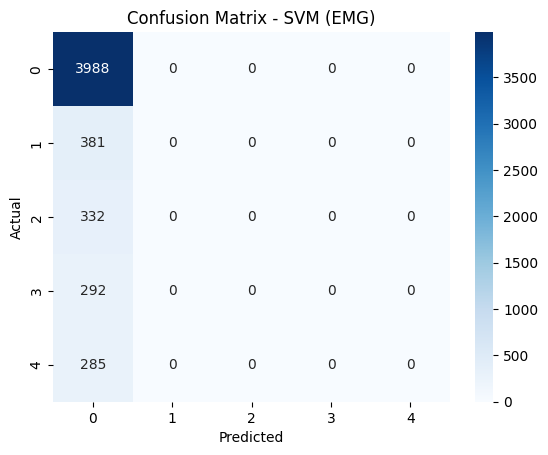


Classifier: XGBoost
Accuracy: 0.8475
F1 Score: 0.8361
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      3988
           1       0.74      0.42      0.54       381
           2       0.85      0.51      0.64       332
           3       0.75      0.64      0.69       292
           4       0.73      0.59      0.65       285

    accuracy                           0.85      5278
   macro avg       0.79      0.62      0.68      5278
weighted avg       0.84      0.85      0.84      5278



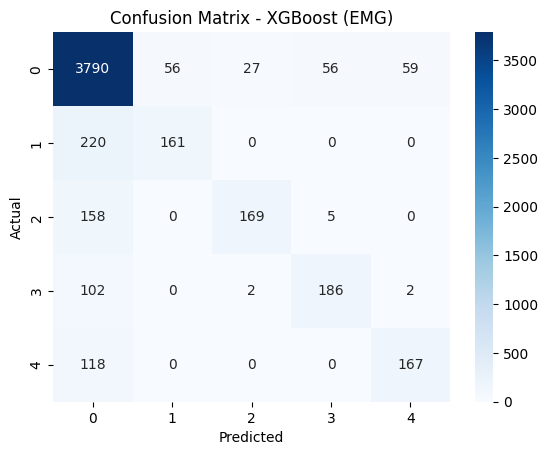


Performance of ensemble model (Voting Classifier) for EMG:
Accuracy: 0.8132
F1 Score: 0.7710
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      3988
           1       0.80      0.15      0.25       381
           2       0.93      0.24      0.38       332
           3       0.86      0.43      0.57       292
           4       0.90      0.33      0.48       285

    accuracy                           0.81      5278
   macro avg       0.86      0.43      0.51      5278
weighted avg       0.82      0.81      0.77      5278



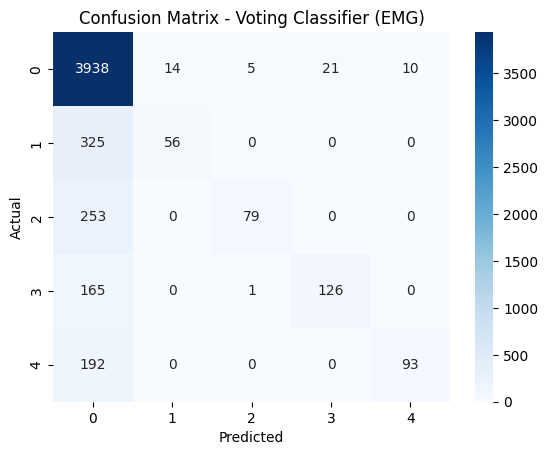

In [9]:
# Evaluate individual classifiers for df2
print("Performance of individual classifiers for EMG:")
for name, clf in classifiers.items():
    clf.fit(X2_train_resampled, y2_train_resampled)
    y_pred = clf.predict(X2_test)
    
    print(f"\nClassifier: {name}")
    print(f"Accuracy: {accuracy_score(y2_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y2_test, y_pred, average='weighted'):.4f}")
    print("Classification Report:")
    print(classification_report(y2_test, y_pred))
    
    # Plot confusion matrix
    plot_confusion_matrix(y2_test, y_pred, f'Confusion Matrix - {name} (EMG)')

# Evaluate the ensemble model for df2
print("\nPerformance of ensemble model (Voting Classifier) for EMG:")
y_pred_df2_ensemble = voting_clf_df2.predict(X2_test)
print(f"Accuracy: {accuracy_score(y2_test, y_pred_df2_ensemble):.4f}")
print(f"F1 Score: {f1_score(y2_test, y_pred_df2_ensemble, average='weighted'):.4f}")
print("Classification Report:")
print(classification_report(y2_test, y_pred_df2_ensemble))

# Plot confusion matrix for ensemble model
plot_confusion_matrix(y2_test, y_pred_df2_ensemble, 'Confusion Matrix - Voting Classifier (EMG)')


**Evaluating the Ensemble model of EOG and EMG**

In [10]:
# Ensure both predictions have the same length
min_len = min(len(df1_test_predictions), len(df2_test_predictions))
df1_test_predictions = df1_test_predictions[:min_len]
df2_test_predictions = df2_test_predictions[:min_len]
y1_test = y1_test[:min_len]

# Combine predictions from the test data for evaluation
X_combined_test = pd.DataFrame({
    'df1': df1_test_predictions,
    'df2': df2_test_predictions
})

# Get predictions from the stacking classifier
y_combined_pred = stacked_clf.predict(X_combined_test)

# Evaluate the combined model
accuracy = accuracy_score(y1_test, y_combined_pred)
f1 = f1_score(y1_test, y_combined_pred, average='weighted')
precision = precision_score(y1_test, y_combined_pred, average='weighted')
recall = recall_score(y1_test, y_combined_pred, average='weighted')

print("Stacking Model Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Classification Report:")
print(classification_report(y1_test, y_combined_pred))
print("Confusion Matrix:")
print(confusion_matrix(y1_test, y_combined_pred))


Stacking Model Results:
Accuracy: 0.9913
F1 Score: 0.9913
Precision: 0.9914
Recall: 0.9913
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98        63
           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        79
           3       0.96      0.98      0.97        55
           4       1.00      1.00      1.00        73

    accuracy                           0.99       346
   macro avg       0.99      0.99      0.99       346
weighted avg       0.99      0.99      0.99       346

Confusion Matrix:
[[61  0  0  2  0]
 [ 0 76  0  0  0]
 [ 0  0 79  0  0]
 [ 1  0  0 54  0]
 [ 0  0  0  0 73]]


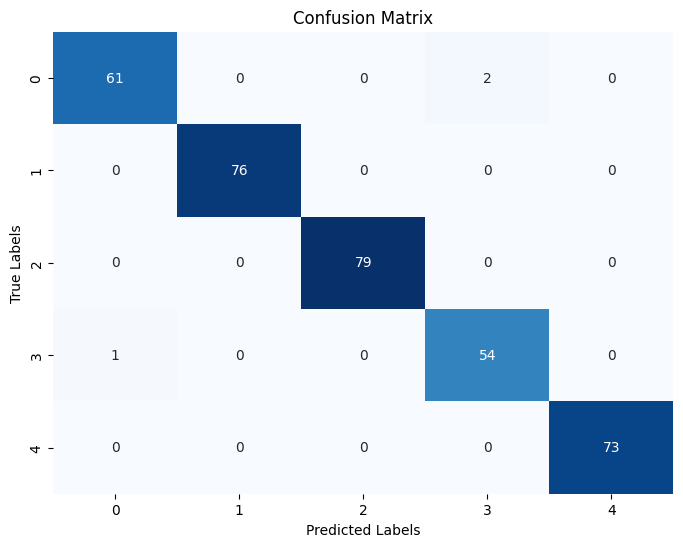

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y1_test, y_combined_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
